In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import itertools
import re
import collections
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()


In [2]:
df = pd.read_parquet("df.parquet")

In [3]:
df

,record_id,product,description,sub_category,brand,company,company_parent,market_country,store_name,store_type,import_status,unit_price,percentile,premium,doc_vec,description_token,description_wv
0,7146579,Nocturnal Nectar Bio-Fermented Facial Essence,"Named after an English wild-flower meadow, Aml...",Face/Neck Care,Amly,Amly Botanicals,Amly Botanicals,Germany,None,None,Imported,402266.00,1.000000,1,"[-0.33388913, 2.1469963, 0.96274215, -0.878904...","[name, english, wild, flower, meadow, amli, de...","[[-0.051982604, -0.08290577, 0.3159616, 0.0085..."
1,6444419,Micro Needling Pimple Patches,Vice Reversa aims to focus on targeted deliver...,Face/Neck Care,Vice Reversa,A Beauty Story,A Beauty Story,UK,Victoria Health,Internet/Mail Order,Imported,265200.00,0.999939,1,"[0.59363365, 2.8043451, 0.6298298, -1.0089695,...","[vice, reversa, aim, focu, target, deliveri, s...","[[0.3694772, -0.57862556, -2.0269456, -0.64512..."
2,6993711,Capsules Protection Totale Face Treatment Oil,The Jean d'Arcel Renovar collection is said to...,Face/Neck Care,Jean d'Arcel Renovar,Jean d'Arcel Cosmétique,Jean d'Arcel Cosmétique,Germany,Feel-Beauty.de,Internet/Mail Order,Not imported,242950.00,0.999878,1,"[0.39346665, -1.5720978, 0.32630467, -0.300545...","[jean, arcel, renovar, collect, said, featur, ...","[[0.8480468, -0.055171926, -0.54320484, 0.1345..."
3,6444421,Micro Needling Plumping Patches,Vice Reversa aims to focus on targeted deliver...,Face/Neck Care,Vice Reversa,A Beauty Story,A Beauty Story,UK,Victoria Health,Internet/Mail Order,Imported,232350.00,0.999817,1,"[0.16396545, 2.3078039, 1.7311268, -0.7228534,...","[vice, reversa, aim, focu, target, deliveri, s...","[[0.3694772, -0.57862556, -2.0269456, -0.64512..."
4,6511823,"Dermatite, Psoriasis, Eczema CBD (5%) Skin Rep...",You & Oil products for skin and hair are creat...,Body Care,You & Oil Phyto Derma Therapy,JSC Biokosmetikos,JSC Biokosmetikos,Germany,Savue,Internet/Mail Order,nan,63360.00,0.999757,1,"[1.53203, 1.2907141, -0.31864712, -1.9782542, ...","[oil, product, skin, hair, creat, exclus, ecol...","[[0.9449418, -0.19407645, 0.33627698, -1.56030..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3287,7111519,Body Lotion,Edeka Elkos Body Body Lotion has been relaunch...,Body Care,Edeka Elkos Body,Edeka Zentrale,Edeka Zentrale,Germany,Diska,Supermarket,nan,0.25,0.000122,0,"[-1.3947046, 0.4628543, -0.00500729, 0.6803158...","[edeka, elko, bodi, bodi, lotion, relaunch, ne...","[[0.16146915, 0.81466347, 0.26688766, 1.377136..."
3288,6703603,Special Natural Clay Powder,Seara Argila Natural Especial em Pó (Special N...,Body Care,Seara,Seara Produtos Naturais,Seara Produtos Naturais,Portugal,Continente,Mass Merchandise/Hypermarket,nan,0.25,0.000122,0,"[1.0026945, -0.29684862, 0.1989893, 0.28999498...","[seara, argila, natur, especi, em, pó, special...","[[0.24507636, 0.19971885, 0.1813712, 0.0929433..."
3289,6331657,Coenzyme Q10 Body Milk,Amalfi Skin Care Leite Corporal Coenzima Q10 (...,Body Care,Amalfi Skin Care,Quimi Romar,Quimi Romar,Portugal,Jumbo Auchan,Mass Merchandise/Hypermarket,Imported,0.25,0.000122,0,"[-0.060306523, 0.06860288, 0.31759515, 0.22624...","[amalfi, skin, care, leit, corpor, coenzima, c...","[[-1.9248099, 0.80903107, 0.48631546, 0.015191..."
3290,6855981,Body Milk,Amalfi Skin Care Rosa Mosqueta Leche Corporal ...,Body Care,Amalfi Skin Care Rosa Mosqueta,Quimi Romar,Quimi Romar,Spain,Carrefour,Supermarket,Not imported,0.23,0.000061,0,"[0.009814276, 0.013060865, 0.09264118, 0.71502...","[amalfi, skin, care, rosa, mosqueta, lech, cor...","[[-1.9248099, 0.80903107, 0.48631546, 0.015191..."


Look at cosine similarity Premium vs Premium, Premium vs Non-Premium, Non-Premium vs Non-Premium

In [4]:
# Highest Premium Brand vs Lowest Non-Premium Brand in term of unit_price
a = df['doc_vec'].iloc[0]
b = df['doc_vec'].iloc[3291]
np.dot(a,b)/(np.linalg.norm(a) * np.linalg.norm(b))

0.18499793

In [5]:
# Top 1 Premium Brand vs Top 2 Premium Brand in term of unit_price
a = df['doc_vec'].iloc[0]
b = df['doc_vec'].iloc[1]
np.dot(a,b)/(np.linalg.norm(a) * np.linalg.norm(b))

0.20241445

In [6]:
# Lowest Premium Brand vs Second lowest Premium Brand in term of unit_price
a = df['doc_vec'].iloc[3290]
b = df['doc_vec'].iloc[3291]
np.dot(a,b)/(np.linalg.norm(a) * np.linalg.norm(b))

0.17533217

The differences between above cosine similarity are minimal. It means that the document vectors above are similar. However, the document vectors are just the input of the prediction model.  

Logistic Regression

In [6]:
Premium_NonPremium = df['premium']
Doc_Vec = df['doc_vec']

In [7]:
Doc_Vec_array = np.array(Doc_Vec.values.tolist())

In [8]:
#Split dataset into training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Doc_Vec_array, Premium_NonPremium, test_size=0.2, random_state=100)

In [33]:
X_train

array([[-1.33352196e+00,  2.40045171e-02, -1.66448310e-01, ...,
        -7.33567059e-01,  3.27428937e-01, -3.71708602e-01],
       [-4.39466625e-01,  1.82640761e-01,  1.06200898e+00, ...,
         2.69202024e-01, -1.33528829e+00, -7.87972569e-01],
       [ 8.49326432e-01,  9.40741003e-01, -1.84730247e-01, ...,
        -2.49549642e-01, -2.94388771e+00, -1.54712903e+00],
       ...,
       [-7.08502352e-01,  4.72000152e-01,  7.35374331e-01, ...,
         5.68219900e-01,  4.98221248e-01,  4.93306145e-02],
       [-1.30063444e-01, -3.63060951e-01, -6.21677160e-01, ...,
        -1.21646285e-01,  2.06929818e-01,  1.68720179e-03],
       [ 6.70225024e-01,  4.34521288e-01,  5.12650251e-01, ...,
         4.96449679e-01,  5.39018869e-01,  4.81423527e-01]], dtype=float32)

In [34]:
X_train.shape

(2633, 300)

In [35]:
len(X_train)

2633

In [36]:
len(y_train)

2633

In [37]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\we704\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
y_pred_log = logreg.predict(X_test)

In [39]:
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred_log))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred_log, average='weighted')))

Testing accuracy 0.9423368740515933
Testing F1 score: 0.9423419238275568


In [40]:
axis = ['Budget', 'Premium']

Text(21.453125, 0.5, 'predicted label')

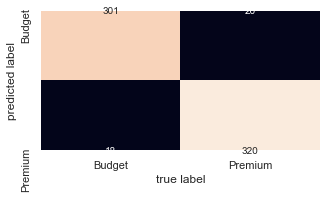

In [42]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(5,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels = axis, yticklabels = axis)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [43]:
mat

array([[301,  18],
       [ 20, 320]], dtype=int64)

Naive Bayes

In [44]:
description = df['description']

In [45]:
description_array = np.array(description.values.tolist())

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(description_array, Premium_NonPremium, test_size=0.2, random_state=100)

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

NB_model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [48]:
NB_model.fit(X_train, y_train)
y_pred_nb = NB_model.predict(X_test)

In [49]:
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred_nb))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred_nb, average='weighted')))

Testing accuracy 0.9711684370257967
Testing F1 score: 0.9711390146862073


Text(21.453125, 0.5, 'predicted label')

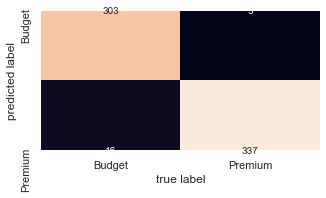

In [50]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(5,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels = axis, yticklabels = axis)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [51]:
mat

array([[303,  16],
       [  3, 337]], dtype=int64)

Some basic neural network models

In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

In [9]:
#Split dataset into training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Doc_Vec_array, Premium_NonPremium, test_size=0.2, random_state=100)

In [55]:
clf_V1 = MLPClassifier(hidden_layer_sizes = (100), verbose = True).fit(X_train, y_train)

Iteration 1, loss = 0.46574179
Iteration 2, loss = 0.19669695
Iteration 3, loss = 0.12891700
Iteration 4, loss = 0.09648525
Iteration 5, loss = 0.07670591
Iteration 6, loss = 0.06367714
Iteration 7, loss = 0.05429198
Iteration 8, loss = 0.04656680
Iteration 9, loss = 0.04035391
Iteration 10, loss = 0.03601657
Iteration 11, loss = 0.03189974
Iteration 12, loss = 0.02875046
Iteration 13, loss = 0.02633269
Iteration 14, loss = 0.02370693
Iteration 15, loss = 0.02166597
Iteration 16, loss = 0.01979246
Iteration 17, loss = 0.01951179
Iteration 18, loss = 0.01707640
Iteration 19, loss = 0.01541515
Iteration 20, loss = 0.01408727
Iteration 21, loss = 0.01308746
Iteration 22, loss = 0.01209270
Iteration 23, loss = 0.01119248
Iteration 24, loss = 0.01053961
Iteration 25, loss = 0.00986721
Iteration 26, loss = 0.00916633
Iteration 27, loss = 0.00852648
Iteration 28, loss = 0.00805545
Iteration 29, loss = 0.00752483
Iteration 30, loss = 0.00702379
Iteration 31, loss = 0.00662164
Iteration 32, los

In [56]:
y_pred_clf1 = clf_V1.predict(X_test)

In [57]:
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred_clf1))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred_clf1, average='weighted')))

Testing accuracy 0.9499241274658573
Testing F1 score: 0.9499215878696965


Text(21.453125, 0.5, 'predicted label')

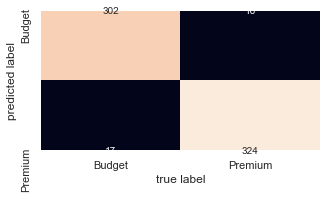

In [58]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred_clf1)
plt.figure(figsize=(5,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels = axis, yticklabels = axis)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [59]:
mat

array([[302,  17],
       [ 16, 324]], dtype=int64)

With 4 hidden lyaers of 100, 100, 100, 50 units respectively

In [61]:
clf_V2 = MLPClassifier(hidden_layer_sizes = (100, 100, 100, 50),  verbose = True).fit(X_train, y_train)

Iteration 1, loss = 0.54012129
Iteration 2, loss = 0.16046386
Iteration 3, loss = 0.08402523
Iteration 4, loss = 0.04243762
Iteration 5, loss = 0.02551748
Iteration 6, loss = 0.01724193
Iteration 7, loss = 0.01270231
Iteration 8, loss = 0.00775627
Iteration 9, loss = 0.00624483
Iteration 10, loss = 0.00475254
Iteration 11, loss = 0.00259639
Iteration 12, loss = 0.00154555
Iteration 13, loss = 0.00101008
Iteration 14, loss = 0.00066773
Iteration 15, loss = 0.00051017
Iteration 16, loss = 0.00042416
Iteration 17, loss = 0.00036844
Iteration 18, loss = 0.00032367
Iteration 19, loss = 0.00029678
Iteration 20, loss = 0.00027185
Iteration 21, loss = 0.00025272
Iteration 22, loss = 0.00023606
Iteration 23, loss = 0.00022429
Iteration 24, loss = 0.00021284
Iteration 25, loss = 0.00020409
Iteration 26, loss = 0.00019619
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [62]:
y_pred_clf2 = clf_V2.predict(X_test)

In [64]:
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred_clf2))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred_clf2, average='weighted')))

Testing accuracy 0.9575113808801214
Testing F1 score: 0.9575068749032509


Text(21.453125, 0.5, 'predicted label')

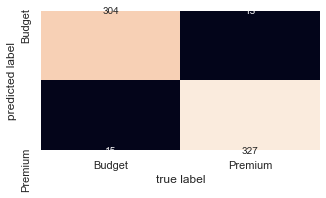

In [65]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred_clf2)
plt.figure(figsize=(5,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels = axis, yticklabels = axis)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [66]:
mat

array([[304,  15],
       [ 13, 327]], dtype=int64)

 hyper-parameter optimization

In [29]:
mlp_gs = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(100,100,100,50),(100,100,50),(100,50),(100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=100,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_sta...
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes

In [30]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}


In [32]:
y_pred_clf_tune = clf.predict(X_test)

In [33]:
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred_clf_tune))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred_clf_tune, average='weighted')))

Testing accuracy 0.9590288315629742
Testing F1 score: 0.9590307201530918
